# Single-channel statistics
Contrast spectral parameters between baseline and encoding, at the single-electrode level

## Set-up

### imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import permutation_test, ttest_rel
from statsmodels.stats.multitest import multipletests

import sys
sys.path.append("../code")
from paths import PROJECT_PATH
from stats import mean_difference
from settings import BANDS


### settings

In [2]:
# settings
ALPHA = 0.05 # significance level
FEATURES = ['exponent', 'alpha', 'alpha_adj', 'gamma', 'gamma_adj']

### load data

In [3]:
# load channel info
chan_info = pd.read_csv(f"{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.csv", index_col=0)
chan_info

,index,patient,chan_idx,label,pos_y,pos_x,pos_z
0,9,pat02,0,A01-A02,-65.43100,61.94490,3.55955
1,10,pat02,1,A02-A03,-70.93895,57.17765,12.15540
2,11,pat02,2,A03-A04,-75.39550,51.39440,20.94335
3,12,pat02,3,A04-A05,-78.91950,43.90980,30.13485
4,13,pat02,4,A05-A06,-80.96735,35.21485,38.13475
...,...,...,...,...,...,...,...
690,1385,pat22,48,MOF_03-MOF_04,36.00000,-14.00000,3.00000
691,1386,pat22,49,MOF_04-MOF_07,40.50000,-14.00000,9.50000
692,1387,pat22,50,MOF_07-MOF_08,44.50000,-14.00000,16.50000
693,1388,pat22,51,MOF_08-MOF_09,48.00000,-14.00000,23.50000


In [4]:
# load single-trial spectral parameters
df = pd.read_csv(f"{PROJECT_PATH}/data/results/psd_trial_params.csv")
df = df.loc[df['memory']=='hit']
df

,patient,trial,chan_idx,material,memory,epoch,ap_mode,offset,exponent,error,r_squared,r2_adj,alpha,alpha_adj,gamma,gamma_adj,knee
0,pat02,0,0,faces,hit,post,fixed,6.675666,2.521925,0.408902,0.701993,0.685437,3.784398,4.416340,2.128099,1.854503,NaN
1,pat02,0,1,faces,hit,post,fixed,5.855543,2.131122,0.407990,0.637631,0.629838,3.458305,3.782459,1.916144,1.746649,NaN
2,pat02,0,2,faces,hit,post,fixed,5.872600,1.971668,0.416719,0.581182,0.572175,3.711390,3.955754,2.276487,2.178522,NaN
3,pat02,0,3,faces,hit,post,fixed,5.810196,1.824834,0.392473,0.550786,0.541125,3.712280,4.576300,2.486117,2.324858,NaN
4,pat02,0,4,faces,hit,post,fixed,6.205565,2.189813,0.407078,0.655923,0.648524,4.055515,3.903695,2.186920,2.265435,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542699,pat22,57,48,words,hit,pre,knee,5.360639,2.970151,0.435862,0.727372,0.718482,2.261792,2.012457,-0.167861,-0.323846,-28.168646
542700,pat22,57,49,words,hit,pre,knee,6.240518,3.066793,0.495311,0.668732,0.657930,3.139316,2.832007,0.630701,0.740823,-19.576435
542701,pat22,57,50,words,hit,pre,knee,6.991722,3.426955,0.471361,0.768017,0.760452,2.972699,2.847320,0.625706,0.801979,496.603688
542702,pat22,57,51,words,hit,pre,knee,7.138637,3.136275,0.404338,0.802373,0.795929,4.059560,4.082807,1.378580,1.320798,-92.372216


### plot histogram of specparam r-squared 

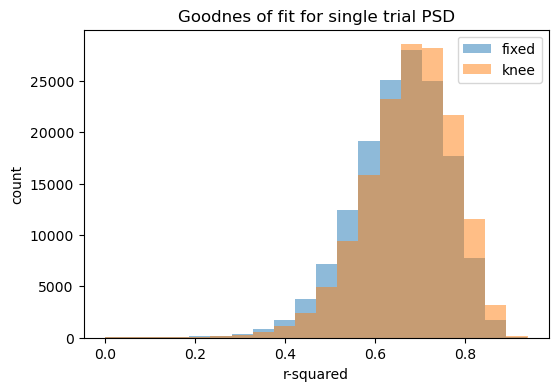

In [5]:
# plot hist of r-squared values for both ap_modes
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(df.loc[df['ap_mode']=='fixed', 'r_squared'], bins=20, alpha=0.5, label='fixed')
ax.hist(df.loc[df['ap_mode']=='knee', 'r_squared'], bins=20, alpha=0.5, label='knee')
ax.set(xlabel="r-squared", ylabel="count")
ax.set_title("Goodnes of fit for single trial PSD")
ax.legend()
plt.show()

# Get data for 'knee' condition
df = df.loc[df['ap_mode']=='knee']


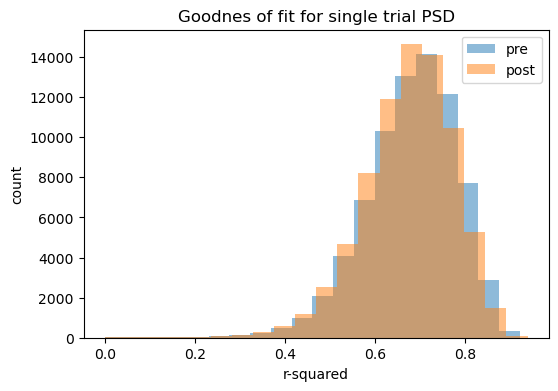

In [6]:
# plot hist of r-squared values for pre and post
df = df.drop(columns=['memory', 'ap_mode'])

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(df.loc[df['epoch']=='pre', 'r_squared'], bins=20, alpha=0.5, label='pre')
ax.hist(df.loc[df['epoch']=='post', 'r_squared'], bins=20, alpha=0.5, label='post')
ax.set(xlabel="r-squared", ylabel="count")
ax.set_title("Goodnes of fit for single trial PSD")
ax.legend()
plt.show()

## Main

### Run stats
- paired T-test
- permutation test

In [7]:
# # run paired t-test - combine 'word' and 'face' conditions

# df_p = chan_info.copy()

# # run stats for each channel
# for i_row, row in df_p.iterrows():
#     print(f"Processing {i_row+1}/{len(df_p)}")
#     df_i = df.loc[(df['patient']==row['patient']) & \
#                   (df['chan_idx']==row['chan_idx'])]
    
#     # analyze each spectral feature
#     for feature in FEATURES:
#         # get single-trial features for a given channel
#         values_pre = df_i.loc[df_i['epoch']=='pre', feature].values
#         values_post = df_i.loc[df_i['epoch']=='post', feature].values

#         # run paired t-test
#         stats = ttest_rel(values_pre, values_post, nan_policy='omit')
#         df_p.loc[i_row, f'{feature}_t'] = stats.statistic
#         df_p.loc[i_row, f'{feature}_p'] = stats.pvalue

# # save results
# df_p.to_csv(f"{PROJECT_PATH}/data/results/single_channel_stats.csv")

# df_p

In [8]:
# # run permutation test - combine 'word' and 'face' conditions

# N_ITER = 1000

# df_p = chan_info.copy()

# for i_row, row in df_p.iterrows():
#     print(f"Processing {i_row+1}/{len(df_p)}")
#     df_i = df.loc[(df['patient']==row['patient']) & \
#                   (df['chan_idx']==row['chan_idx'])]
#     for feature in FEATURES:
#         values_pre = df_i.loc[df_i['epoch']=='pre', feature].values
#         values_post = df_i.loc[df_i['epoch']=='post', feature].values

#         stats = permutation_test([values_pre, values_post], 
#                             statistic=mean_difference, 
#                             permutation_type='samples',
#                             n_resamples=N_ITER,
#                             alternative='two-sided',
#                             random_state=0)
#         df_p.loc[i_row, f'{feature}_t'] = stats.statistic
#         df_p.loc[i_row, f'{feature}_p'] = stats.pvalue

# save results
# df_p.to_csv(f"{PROJECT_PATH}/data/results/single_channel_permutation.csv")

# df_p

### analyze results
count number of significant channels

In [9]:
# load results from above
# df_p = pd.read_csv(f"{PROJECT_PATH}/data/results/single_channel_permutation.csv", index_col=0)
df_p = pd.read_csv(f"{PROJECT_PATH}/data/results/single_channel_stats.csv", index_col=0)
df_p

,index,patient,chan_idx,label,pos_y,pos_x,pos_z,exponent_t,exponent_p,alpha_t,alpha_p,alpha_adj_t,alpha_adj_p,gamma_t,gamma_p,gamma_adj_t,gamma_adj_p
0,9,pat02,0,A01-A02,-65.43100,61.94490,3.55955,2.835601,5.436901e-03,1.676486,9.645729e-02,3.030348,0.003045,0.404330,6.867484e-01,-0.119329,0.905230
1,10,pat02,1,A02-A03,-70.93895,57.17765,12.15540,3.645792,3.991216e-04,3.047198,2.855607e-03,2.396835,0.018121,0.965618,3.362269e-01,-0.416101,0.678098
2,11,pat02,2,A03-A04,-75.39550,51.39440,20.94335,3.741851,2.685186e-04,6.055645,1.287034e-08,4.059815,0.000083,-3.266588,1.377849e-03,-2.813170,0.005633
3,12,pat02,3,A04-A05,-78.91950,43.90980,30.13485,3.291578,1.273745e-03,2.215688,2.840065e-02,1.180514,0.239887,-0.451134,6.526225e-01,0.378919,0.705348
4,13,pat02,4,A05-A06,-80.96735,35.21485,38.13475,2.714708,7.513506e-03,4.745391,5.297972e-06,3.722206,0.000292,1.569405,1.189297e-01,1.217230,0.225672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,1385,pat22,48,MOF_03-MOF_04,36.00000,-14.00000,3.00000,0.251394,8.019919e-01,-0.302382,7.629481e-01,-2.328770,0.021768,0.866149,3.883465e-01,0.787370,0.432806
691,1386,pat22,49,MOF_04-MOF_07,40.50000,-14.00000,9.50000,0.549385,5.838758e-01,2.187215,3.088321e-02,1.617989,0.108723,1.395341,1.657756e-01,1.415666,0.159751
692,1387,pat22,50,MOF_07-MOF_08,44.50000,-14.00000,16.50000,1.740700,8.455814e-02,0.433874,6.652372e-01,0.931518,0.353764,1.634162,1.051099e-01,1.466778,0.145316
693,1388,pat22,51,MOF_08-MOF_09,48.00000,-14.00000,23.50000,3.953345,1.372780e-04,-0.755971,4.512970e-01,0.321435,0.748514,-5.813815,6.170116e-08,-5.145211,0.000001


In [10]:
# # print minimum p-values
# print("Minimum p-values:")
# for feature in FEATURES:
#     p_values = df_p[f'{feature}_p'].values
#     print(f"    {feature}: \t{np.nanmin(p_values):0.1e}")

In [11]:
# count the number of channels with a significant difference (increase and 
# decrease seperately) for each feature - across all channels

# count
for feature in FEATURES:
    df_p[f'{feature}_sig'] = 0
    df_p.loc[(df_p[f'{feature}_p']<0.05) & (df_p[f'{feature}_t']>0), f'{feature}_sig'] = -1 # ! this is different for permutation test and t-test (sign of t-statistic) !
    df_p.loc[(df_p[f'{feature}_p']<0.05) & (df_p[f'{feature}_t']<0), f'{feature}_sig'] = 1 # ! this is different for permutation test and t-test (sign of t-statistic) !

# print
for feature in FEATURES:
    print(f"\n{feature}:")
    print(f"\tIncrease: {df_p.loc[df_p[f'{feature}_sig']==1].shape[0]} ({df_p.loc[df_p[f'{feature}_sig']==1].shape[0]/df_p.shape[0]*100:.2f}%)")
    print(f"\tDecrease: {df_p.loc[df_p[f'{feature}_sig']==-1].shape[0]} ({df_p.loc[df_p[f'{feature}_sig']==-1].shape[0]/df_p.shape[0]*100:.2f}%)")
    print(f"\tNo change: {df_p.loc[df_p[f'{feature}_sig']==0].shape[0]} ({df_p.loc[df_p[f'{feature}_sig']==0].shape[0]/df_p.shape[0]*100:.2f}%)")


exponent:
	Increase: 32 (4.60%)
	Decrease: 210 (30.22%)
	No change: 453 (65.18%)

alpha:
	Increase: 135 (19.42%)
	Decrease: 144 (20.72%)
	No change: 416 (59.86%)

alpha_adj:
	Increase: 93 (13.38%)
	Decrease: 135 (19.42%)
	No change: 467 (67.19%)

gamma:
	Increase: 181 (26.04%)
	Decrease: 121 (17.41%)
	No change: 393 (56.55%)

gamma_adj:
	Increase: 150 (21.58%)
	Decrease: 92 (13.24%)
	No change: 453 (65.18%)


In [12]:
# count number of task-modulated channels with significant effects

# reduce to task-modulated channels
df_mod = pd.read_csv(f"{PROJECT_PATH}/data/results/ieeg_modulated_channels.csv", 
                     index_col=0)
df_sig = df_p.loc[df_mod['sig_all']]
print(f"N task-modulated channels: {df_sig.shape[0]}")

# print counts
for feature in FEATURES:
    print(f"\n{feature}:")
    print(f"\tIncrease: {df_sig.loc[df_sig[f'{feature}_sig']==1].shape[0]} ({df_sig.loc[df_sig[f'{feature}_sig']==1].shape[0]/df_sig.shape[0]*100:.2f}%)")
    print(f"\tDecrease: {df_sig.loc[df_sig[f'{feature}_sig']==-1].shape[0]} ({df_sig.loc[df_sig[f'{feature}_sig']==-1].shape[0]/df_sig.shape[0]*100:.2f}%)")
    print(f"\tNo change: {df_sig.loc[df_sig[f'{feature}_sig']==0].shape[0]} ({df_sig.loc[df_sig[f'{feature}_sig']==0].shape[0]/df_sig.shape[0]*100:.2f}%)")

N task-modulated channels: 61

exponent:
	Increase: 0 (0.00%)
	Decrease: 24 (39.34%)
	No change: 37 (60.66%)

alpha:
	Increase: 8 (13.11%)
	Decrease: 29 (47.54%)
	No change: 24 (39.34%)

alpha_adj:
	Increase: 5 (8.20%)
	Decrease: 28 (45.90%)
	No change: 28 (45.90%)

gamma:
	Increase: 28 (45.90%)
	Decrease: 8 (13.11%)
	No change: 25 (40.98%)

gamma_adj:
	Increase: 28 (45.90%)
	Decrease: 8 (13.11%)
	No change: 25 (40.98%)


### Correct for multiple comparison

In [13]:
# # show in simulation the expected FPR for permutation test

# N_ITER = 1000 # number of iterations
# N = 100 # number of samples

# # run permutation test on random data
# p_values = np.zeros(N_ITER)
# for i in range(N_ITER):
#     data_0 = np.random.normal(0, 1, N)
#     data_1 = np.random.normal(0, 1, N)
#     p_values[i] = permutation_test([data_0, data_1], 
#                                     statistic=mean_difference, 
#                                     permutation_type='samples',
#                                     n_resamples=1000,
#                                     alternative='two-sided',
#                                     random_state=0).pvalue

# # plot hist of p-values
# fig, ax = plt.subplots(1,1, figsize=[6,4])
# ax.hist(p_values, bins=20)
# ax.set(xlabel="p-value", ylabel="count")
# ax.set_title("Permutation test FPR")
# plt.show()

# # print proportion of false positive
# print(f"Expected FPR: {np.sum(p_values<0.05)/N_ITER}")


In [14]:
# compute corrected pvalues - all channels

# correct p-values
for feature in FEATURES:
    results = multipletests(df_p[f"{feature}_p"], alpha=0.05, method='holm')
    df_p.insert(df_p.shape[1], f"{feature}_pval_corr", results[1])

# determine significance and direction of effect
for feature in FEATURES:
    df_p[f'{feature}_sig_corr'] = 0
    df_p.loc[(df_p[f'{feature}_pval_corr']<0.05) & (df_p[f'{feature}_t']>0), f'{feature}_sig_corr'] = -1 # ! this is different for permutation test and t-test (sign of t-statistic) !
    df_p.loc[(df_p[f'{feature}_pval_corr']<0.05) & (df_p[f'{feature}_t']<0), f'{feature}_sig_corr'] = 1 # ! this is different for permutation test and t-test (sign of t-statistic) !

# print number of significant channels
for feature in FEATURES:
    print(f"\n{feature}:")
    print(f"\tIncrease: {df_p.loc[df_p[f'{feature}_sig_corr']==1].shape[0]} ({df_p.loc[df_p[f'{feature}_sig_corr']==1].shape[0]/df_p.shape[0]*100:.2f}%)")
    print(f"\tDecrease: {df_p.loc[df_p[f'{feature}_sig_corr']==-1].shape[0]} ({df_p.loc[df_p[f'{feature}_sig_corr']==-1].shape[0]/df_p.shape[0]*100:.2f}%)")
    print(f"\tNo change: {df_p.loc[df_p[f'{feature}_sig_corr']==0].shape[0]} ({df_p.loc[df_p[f'{feature}_sig_corr']==0].shape[0]/df_p.shape[0]*100:.2f}%)")



exponent:
	Increase: 1 (0.14%)
	Decrease: 65 (9.35%)
	No change: 629 (90.50%)

alpha:
	Increase: 24 (3.45%)
	Decrease: 64 (9.21%)
	No change: 607 (87.34%)

alpha_adj:
	Increase: 11 (1.58%)
	Decrease: 50 (7.19%)
	No change: 634 (91.22%)

gamma:
	Increase: 76 (10.94%)
	Decrease: 21 (3.02%)
	No change: 598 (86.04%)

gamma_adj:
	Increase: 62 (8.92%)
	Decrease: 11 (1.58%)
	No change: 622 (89.50%)


In [15]:
# compute corrected pvalues - task-modulated channels

# correct p-values
for feature in FEATURES:
    results = multipletests(df_sig[f"{feature}_p"], alpha=0.05, method='holm')
    df_sig.insert(df_sig.shape[1], f"{feature}_pval_corr", results[1])

# determine significance and direction of effect
for feature in FEATURES:
    df_sig.insert(df_sig.shape[1], f'{feature}_sig_corr', 0)
    df_sig.loc[(df_sig[f'{feature}_pval_corr']<0.05) & (df_sig[f'{feature}_t']>0), f'{feature}_sig_corr'] = -1 # ! this is different for permutation test and t-test (sign of t-statistic) !
    df_sig.loc[(df_sig[f'{feature}_pval_corr']<0.05) & (df_sig[f'{feature}_t']<0), f'{feature}_sig_corr'] = 1 # ! this is different for permutation test and t-test (sign of t-statistic) !

# print number of significant channels
for feature in FEATURES:
    print(f"\n{feature}:")
    print(f"\tIncrease: {df_sig.loc[df_sig[f'{feature}_sig_corr']==1].shape[0]} ({df_sig.loc[df_sig[f'{feature}_sig_corr']==1].shape[0]/df_sig.shape[0]*100:.2f}%)")
    print(f"\tDecrease: {df_sig.loc[df_sig[f'{feature}_sig_corr']==-1].shape[0]} ({df_sig.loc[df_sig[f'{feature}_sig_corr']==-1].shape[0]/df_sig.shape[0]*100:.2f}%)")
    print(f"\tNo change: {df_sig.loc[df_sig[f'{feature}_sig_corr']==0].shape[0]} ({df_sig.loc[df_sig[f'{feature}_sig_corr']==0].shape[0]/df_sig.shape[0]*100:.2f}%)")


exponent:
	Increase: 0 (0.00%)
	Decrease: 15 (24.59%)
	No change: 46 (75.41%)

alpha:
	Increase: 4 (6.56%)
	Decrease: 26 (42.62%)
	No change: 31 (50.82%)

alpha_adj:
	Increase: 1 (1.64%)
	Decrease: 24 (39.34%)
	No change: 36 (59.02%)

gamma:
	Increase: 28 (45.90%)
	Decrease: 6 (9.84%)
	No change: 27 (44.26%)

gamma_adj:
	Increase: 27 (44.26%)
	Decrease: 4 (6.56%)
	No change: 30 (49.18%)
